# Capstone Project - Amazon Review Analysis

For my Capstone project for the DSI Immersive Program at General Assembly I am going to attempt to predict whether or not an Amazon review gave a 5-star rating based solely off of the text and summary of the review. I will be implementing several different Natural Language Processing techniques in order to do this. Along the way I will also look at what words or sets of words are best for for this prediction, which should have a great business-use of showing what features of a product customers are looking for.

### Fetching Data

All of the Amazon review data can be found here: http://jmcauley.ucsd.edu/data/amazon/

I will be using only the Electronics subsection, as I believe that this is the section where I have the most domain knowledge, while still being an extremely sizable dataset at ~1.6million entries.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import json
import gzip

In [2]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield eval(l)

In [3]:
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF("/Users/stephenhockey/Downloads/reviews_Electronics_5.json.gz")

df.shape

(1689188, 9)

Because we are solely using Natural Language Processing for this prediction, and we have a very large dataset of more than 1.6 million reviews, I will cut this down by removing all entries with the text of the review being less than 100 characters, and all entries with the summary of the review being less than 5 characters (pretty much just getting rid of reviews with empty or useless summaries).

In [4]:
df = df[df.reviewText.apply(lambda x: len(x) >= 100) == True]
df.shape

(1648246, 9)

In [5]:
from string import punctuation

In [6]:
# From some later investigation it seems that there are some reviews with summaries longer than
# 5 characters that consist solely of white space or punctuation. To also remove these we will 
# strip all white space and punctuation from the summary before counting the length.

def remove_spaces_and_punctuation(text):
    text = text.replace(' ', '')
    text = text.translate(str.maketrans('', '', punctuation))
    return text

dfcopy = df.copy()
dfcopy.summary = dfcopy.summary.apply(remove_spaces_and_punctuation)
df = df[dfcopy.summary.apply(lambda x: len(x) >= 5)]

# reseting the index so there are not numbers skipped 
df.index = range(df.shape[0])
df.shape

(1621241, 9)

It does not seem like there were very many reviews with a text length of less than 100 characters or a summary of less than 5 characters, as only about 70,000 of the entries were dropped.

### Initial Look at Data

In [7]:
df.head()
# The helpful column looks like it could possibly be a good feature, subtracting the second
# number from the first, however, I want to see how we can do with only using the text columns

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3.0,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2.0,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1.0,"Major issues, only excuses for support",1317254400,"09 29, 2011"


In [8]:
# Null values
df.isnull().sum()

reviewerID            0
asin                  0
reviewerName      22897
helpful               0
reviewText            0
overall               0
summary               0
unixReviewTime        0
reviewTime            0
dtype: int64

The only column with any null values is 'reviewerName', which we will be getting rid of anyways. This dataset seems to be very clean already.

Let's take a look at all of the different ratings and how often they occur in the dataset.

In [9]:
df['overall'].value_counts()

5.0    966299
4.0    335482
3.0    136141
1.0    103846
2.0     79473
Name: overall, dtype: int64

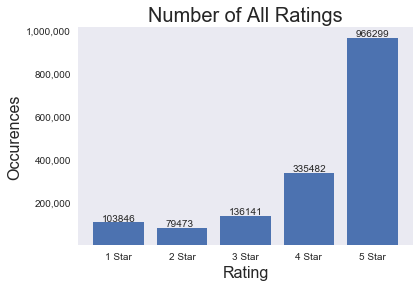

In [10]:
# Number of each rating visualized

bars = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = [df['overall'].value_counts()[1.0], df['overall'].value_counts()[2.0], 
          df['overall'].value_counts()[3.0], df['overall'].value_counts()[4.0], 
          df['overall'].value_counts()[5.0]]
values = df.overall.value_counts().sort_index().values.tolist()

plt.bar(bars, values)
plt.xticks(bars, ['1 Star', '2 Star', '3 Star', '4 Star', '5 Star'])
plt.yticks([200000, 400000, 600000, 800000, 1000000], 
           ['200,000', '400,000', '600,000', '800,000', '1,000,000'])
plt.ylabel('Occurences', fontsize=16)
plt.xlabel('Rating', fontsize=16)

# Adding the labels, the numbers added or subtracted to each of the x and y values are
# arbitrary, used to center the labels on the column
for i in range(5):
    plt.text(x=bars[i]-0.26, y=values[i]+8000, s=labels[i])
    
plt.title('Number of All Ratings', fontsize=20)
plt.grid(False)
plt.show()

In [11]:
# Checking to see our baseline accuracy that we will try to improve on with our model.
baseline = df['overall'].value_counts()[5.0] / df['overall'].value_counts().sum()
print(baseline)

0.596024280166


Because most of the columns in this dataset seem like they will be completely irrelevant to the rating given with the review, the first step is to filter out only the relevant predictor columns, which would be the 'reviewText' and 'summary', and the target column 'overall'. Since we are just trying to predict whether or not a review's rating was a 5, we can then change all values that aren't a 5 to a 0 and all 5s to a 1.

Out of curiousity, and as a later addition to this project, I will also try to predict whether the rating was five stars, four stars, or any of the other three. The idea for this came from my days as a bank teller, where our interactions with customers would be scored using the Net Promoter Score (short explanation here: https://www.netpromoter.com/know/). Basically, clients we interacted with during the day would be randomly selected to be cold-called, and asked how they would rate their experience in the bank that day on a scale from 1 to 5. The tellers would then get scores based on all of these responses with only a 5 being positive, a 4 being neutral, and any rating lower detracting from our overall score.

I am interested in seeing how accurately the model can predict the rating when four star reviews are separated into their own category. If I had to guess, I would assume that it will be much worse at predicting 4-stars, as there is probably much more of a mix of positive and negative words contained in the text of those reviews than there is in either of the two extremes.

In [12]:
target = df['overall'].apply(lambda x: 1 if x == 5.0 else 0)
multiclass_target = df['overall'].apply(lambda x: 2 if x == 5.0 else 1 if x == 4.0 else 0)
X = df[['reviewText', 'summary']]

In [13]:
target.value_counts()

1    966299
0    654942
Name: overall, dtype: int64

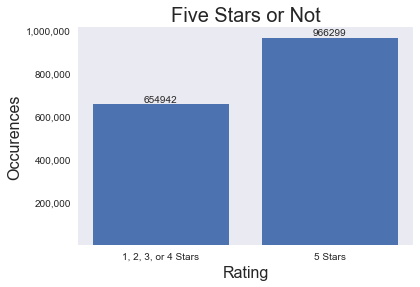

In [14]:
# Binary classification target visualied

bars = [0, 1]
labels = [target.value_counts()[0], target.value_counts()[1]]
values = target.value_counts().sort_index().values.tolist()

plt.bar(bars, values)
plt.xticks(bars, ['1, 2, 3, or 4 Stars', '5 Stars'])
plt.yticks([200000, 400000, 600000, 800000, 1000000], 
           ['200,000', '400,000', '600,000', '800,000', '1,000,000'])
plt.ylabel('Occurences', fontsize=16)
plt.xlabel('Rating', fontsize=16)
for i in range(2):
    plt.text(x=bars[i]-0.1, y=values[i]+11000, s=labels[i])
plt.title('Five Stars or Not', fontsize=20)
plt.grid(False)
plt.show()

In [15]:
multiclass_target.value_counts()

2    966299
1    335482
0    319460
Name: overall, dtype: int64

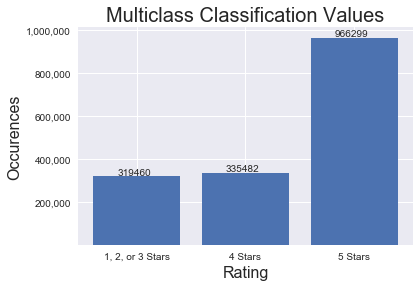

In [16]:
bars = [0, 1, 2]
labels = [multiclass_target.value_counts()[0], multiclass_target.value_counts()[1],
          multiclass_target.value_counts()[2]]
values = multiclass_target.value_counts().sort_index().values.tolist()

plt.bar(bars, values)
plt.xticks(bars, ['1, 2, or 3 Stars', '4 Stars', '5 Stars'])
plt.yticks([200000, 400000, 600000, 800000, 1000000], 
           ['200,000', '400,000', '600,000', '800,000', '1,000,000'])
plt.ylabel('Occurences', fontsize=16)
plt.xlabel('Rating', fontsize=16)
for i in range(3):
    plt.text(x=bars[i]-0.18, y=values[i]+6000, s=labels[i])
plt.title('Multiclass Classification Values', fontsize=20)
plt.show()

We will then use train_test_split to split up our data into training and testing sets in order to test our model on data it has not seen before.

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.1, random_state=24)

In [19]:
# MULTICLASS TARGET SPLIT - We should only have to use the new y-values from this, as the X's
# should all be the same
mutliclass_X_train, multiclass_X_test, multiclass_y_train, multiclass_y_test = \
                        train_test_split(X, multiclass_target, test_size=0.1, random_state=24)

### Natural Language Processing

In [20]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

Since we have two different columns that we will be utilizing Natural Language Processing on, we will need to separate them from both X_train and X_test into their own series. This is so that we have separate values for words contained within both the summary of the review and the text of a review, which should be an important distinction.

In [21]:
X_train_text = X_train['reviewText']
X_train_summary = X_train['summary']
X_test_text = X_test['reviewText']
X_test_summary = X_test['summary']

In [22]:
# Creating our text preprocesser. The function will remove punctuation and numbers from the
# text, change it all into lowercase, and add all words that are not in the english stop-words
# list to a list of final words, while stemming words with the same roots together.

def text_preprocesser(text):
    stemmer = PorterStemmer()
    stop = stopwords.words('english')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.translate(str.maketrans('', '', string.digits))
    text = text.lower().strip()
    final_text = []
    for w in text.split():
        if w not in stop:
            final_text.append(stemmer.stem(w.strip()))
    return ' '.join(final_text)

Because our preprocesser that we will run all of our text through removes all punctuation and case of the text, I will manually create binary classification columns for where the summary and text of a post contains certain punctuation, and a column for the percentage of the text that was upper-case (assuming worse reviews have a higher ratio of capital letters). 

In [23]:
X_train['reviewText_contains_?'] = X_train_text.str.contains('\?').astype(int)
X_train['reviewText_contains_!'] = X_train_text.str.contains('!').astype(int)
X_train['reviewText_contains_!!+'] = X_train_text.str.contains('!!+').astype(int)
X_train['reviewText_contains_??+'] = X_train_text.str.contains('\?\?+').astype(int)

/Users/stephenhockey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/stephenhockey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/stephenhockey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [24]:
X_test['reviewText_contains_?'] = X_test_text.str.contains('\?').astype(int)
X_test['reviewText_contains_!'] = X_test_text.str.contains('!').astype(int)
X_test['reviewText_contains_!!+'] = X_test_text.str.contains('!!+').astype(int)
X_test['reviewText_contains_??+'] = X_test_text.str.contains('\?\?+').astype(int)

/Users/stephenhockey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/stephenhockey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/stephenhockey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [25]:
# Strips the message of punctuation, counts the number of capital letters in the text, then
# divides that number by the length of the text minus the number of spaces. This makes it so
# that punctuation and whitespaces are not included in the total length of the message and
# don't throw off the ratio.
def capital_ratio(message):
    message = message.translate(str.maketrans('', '', punctuation))
    capitals = sum(1 for x in message if x.isupper())
    total = len(message)
    spaces = message.count(' ')
    capital_ratio = capitals / (total - spaces)
    return capital_ratio

In [26]:
X_train['reviewText_capital_ratio'] = X_train_text.apply(capital_ratio)
X_test['reviewText_capital_ratio'] = X_test_text.apply(capital_ratio)
X_train['summary_capital_ratio'] = X_train_summary.apply(capital_ratio)
X_test['summary_capital_ratio'] = X_test_summary.apply(capital_ratio)

/Users/stephenhockey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/stephenhockey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/stephenhockey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [27]:
# We will use the textblob library to determine the polartity (how positive or negative) the
# text was. I'll create a function for this and apply it to all of our text columns.
from textblob import TextBlob

def polarity(text):
    text = TextBlob(text)
    return text.sentiment.polarity

In [28]:
X_train['reviewText_polarity'] = X_train_text.apply(polarity)
X_test['reviewText_polarity'] = X_test_text.apply(polarity)
X_train['summary_polarity'] = X_train_summary.apply(polarity)
X_test['summary_polarity'] = X_test_summary.apply(polarity)

/Users/stephenhockey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/stephenhockey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/stephenhockey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

#### TFIDF Vectorizer

We are now going to run our two text columns through TFIDF Vectorizer to processed columns with values signifying how many times a specific word appears in a document vs. how unique that word is within the entire corpus.

#### reviewText

In [29]:
text_tfidf = TfidfVectorizer(preprocessor=text_preprocesser, min_df=0.001, max_df=0.6)
text_tfidf.fit(X_train_text)

text_tfidf_X_train = text_tfidf.transform(X_train_text)
text_tfidf_X_test = text_tfidf.transform(X_test_text)

#### Summary

In [30]:
summary_tfidf = TfidfVectorizer(preprocessor=text_preprocesser, min_df=0.0001, max_df=0.6)
summary_tfidf.fit(X_train_summary)

summary_tfidf_X_train = summary_tfidf.transform(X_train_summary)
summary_tfidf_X_test = summary_tfidf.transform(X_test_summary)

### Saving My Matrices

Because I am working with NLP on such a large dataset, it takes a VERY long time to fit and transform it with the TFIDF Vectorizer. I've also killed the kernel more than a couple times by attempting to do operations that I have learned I should not do on such a dataset, such as trying to make my TFIDF output matrices dense. To avoid having to wait for these to fit and transform with every future kernel death, I will save my sparse matrices locally using scipy.sparse.save_npz, and load them using scipy.sparse.load_npz.

In [31]:
from scipy.sparse import save_npz, load_npz

In [32]:
save_npz('text_tfidf_X_train.npz', text_tfidf_X_train)
save_npz('text_tfidf_X_test.npz', text_tfidf_X_test)
save_npz('summary_tfidf_X_train.npz', summary_tfidf_X_train)
save_npz('summary_tfidf_X_test.npz', summary_tfidf_X_test)

In [33]:
# text_tfidf_X_train = load_npz('text_tfidf_X_train.npz')
# text_tfidf_X_test = load_npz('text_tfidf_X_test.npz')
# summary_tfidf_X_train = load_npz('summary_tfidf_X_train.npz')
# summary_tfidf_X_test = load_npz('summary_tfidf_X_test.npz')

### Preparation for Modeling

In [34]:
# We can now safely drop our text columns from both X_train and X_test as they have already
# been extracted and processed.

X_train = X_train.drop(['reviewText', 'summary'], axis=1)
X_test = X_test.drop(['reviewText', 'summary'], axis=1)

We will be working only with sparse matrices for our models. Since the dataset is so large, just trying to convert the sparse matrices output from the TFIDF Vectorizer caused my computer to run out of memory. To avoid this, we will just use sparse matrices which are much more efficient to run as they omit all datapoints with a value of 0, which would be a huge amount when you are using NLP.

However, in order to use sparse matrices for our model, we will need to convert our dataframes X_train and X_test with our created features into sparse matrices, and find out how to concatenate sparse matrices together. We will then do that on our text_tfidf, summary_tfidf, and original dataframe(turned into a sparse matrix) for both our training set and testing set of data. We should then be ready to model, using of course, a model that will accept sparse matrices as an input.

In [35]:
# Just confirming that all of our data is the expected shape so that we won't have any issues
# adding them together.

print('Training:', text_tfidf_X_train.shape, summary_tfidf_X_train.shape, X_train.shape)
print('Testing:', text_tfidf_X_test.shape, summary_tfidf_X_test.shape, X_test.shape)

Training: (1459116, 3322) (1459116, 2178) (1459116, 8)
Testing: (162125, 3322) (162125, 2178) (162125, 8)


In [36]:
# We can convert dense matrices such as our X_train and X_test into the same format (Compressed
# Sparse Row) as our tfidf data using scipy.sparse.csr_matrix
from scipy.sparse import csr_matrix

sparse_X_train = csr_matrix(X_train)
sparse_X_test = csr_matrix(X_test)

# Going to once again save these sparse matrices, to be loaded in case of kernel death
save_npz('sparse_X_train', sparse_X_train)
save_npz('sparse_X_test', sparse_X_test)

In [37]:
# sparse_X_train = load_npz('sparse_X_train.npz')
# sparse_X_test = load_npz('sparse_X_test.npz')

In [38]:
# To concatenate our three separate sparse matrices back into just one sparse matrix along the
# x-axis, we can use hstack, also from the scipy.sparse library.

from scipy.sparse import hstack
modeling_tfidf_X_train = hstack((text_tfidf_X_train, summary_tfidf_X_train, sparse_X_train))
modeling_tfidf_X_test = hstack((text_tfidf_X_test, summary_tfidf_X_test, sparse_X_test))

In [39]:
# Our concatenated sparse matrices should have the same number of rows as their respective sets
# above, with the number of columns of all three combined.
print('Expected Number of Columns:', str(text_tfidf_X_train.shape[1] + \
                                         summary_tfidf_X_train.shape[1] + X_train.shape[1]))
print('Training:', modeling_tfidf_X_train.shape) 
print('Testing:', modeling_tfidf_X_test.shape)

Expected Number of Columns: 5508
Training: (1459116, 5508)
Testing: (162125, 5508)


### Modeling - Binary Classification

Remember our baseline accuracy calculated before, this is the score we are aiming to beat with our model. This will be the same for both our binary classification model and our multiclass classification model as the most common value was just 5.0, which is not being changed at all.

In [40]:
print(baseline)

0.596024280166


I will try a few models to see how they each perform with no hyperparameter tuning, and then take the best one from that and use GridSearchCV to attempt to get it as tuned as possible.

In [41]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV

##### Linear Support Vector Classifier

In [42]:
lsvc = LinearSVC()
lsvc.fit(modeling_tfidf_X_train, y_train)

print('LSVC training set accuracy:', lsvc.score(modeling_tfidf_X_train, y_train))
print('LSVC testing set accuracy', 
      cross_val_score(lsvc, modeling_tfidf_X_test, y_test, cv=5).mean())

LSVC training set accuracy: 0.808175635111
LSVC testing set accuracy 0.796299134804


##### Random Forest Classifier

In [43]:
rf = RandomForestClassifier()
rf.fit(modeling_tfidf_X_train, y_train)

print('Random Forest training set accuracy:', rf.score(modeling_tfidf_X_train, y_train))
print('Random Forest testing set accuracy:', 
      cross_val_score(rf, modeling_tfidf_X_test, y_test, cv=3).mean())

Random Forest training set accuracy: 0.991616841978
Random Forest testing set accuracy: 0.729443314003


##### AdaBoost Classifier

In [44]:
abc = AdaBoostClassifier()
abc.fit(modeling_tfidf_X_train, y_train)

print('AdaBoost training set accuracy:', abc.score(modeling_tfidf_X_train, y_train))
print('AdaBoost testing set accuracy:',
     cross_val_score(abc, modeling_tfidf_X_test, y_test, cv=3).mean())

AdaBoost training set accuracy: 0.746083244924
AdaBoost testing set accuracy: 0.745295305342


##### Linear Regression

In [45]:
lr = LinearRegression()
lr.fit(modeling_tfidf_X_train, y_train)

print('Linear Regression training set accuracy:', lr.score(modeling_tfidf_X_train, y_train))
print('Linear Regression testing set accuracy:',
     cross_val_score(lr, modeling_tfidf_X_test, y_test, cv=3).mean())

Linear Regression training set accuracy: 0.403002174003
Linear Regression testing set accuracy: 0.369302761952


It is quite clear from the initial modeling that Linear Support Vector Classifier is the best choice for this data. This is very great for us as it seems to be the one that is quickest with a very large dataset, taking only a couple of minutes to fit while some of the others took hours. 

While Random Forest Classifier has a 99% accuracy on the training data, that drops down to only 73% on the testing data, probably signifying the model is overfit. We will now tune the hyperparameters of LSVC using a GridSearch.

In [46]:
# Because of the size of this dataset and the amount of memory it takes to run things that
# iterate through it many times, I had to limit the gridsearch to just a few permutations on
# each run. To get around this, I just ran the GridSearchCV many times, adjusting the
# parameters lower or higher when they were sitting right on the edge. What you see below is
# the result of many of these separate gridsearches.

gs_lsvc = LinearSVC()

params = {
    'penalty':['l2'],
    'loss': ['hinge'],
    'C': [0.155, 0.16, 0.165, 0.17, 0.175],
    'max_iter': [500]
}

clf = GridSearchCV(gs_lsvc, param_grid=params, n_jobs=-1)
clf.fit(modeling_tfidf_X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)

{'C': 0.165, 'loss': 'hinge', 'max_iter': 500, 'penalty': 'l2'}
0.80579542682


In [47]:
cross_val_score(clf, modeling_tfidf_X_test, y_test, cv=5).mean()

# As you can see, the tuning of the hyperparameters resulted in only 0.4% increase in accuracy 
# over the untuned model. While this may seem insignificant, with a dataset of one million 
# reviews, this would be an extra 4,000 correct classifications.

0.79993212813893722

### Modeling - Multiclass Classification

In [48]:
multiclass_lsvc = LinearSVC()
multiclass_lsvc.fit(modeling_tfidf_X_train, multiclass_y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [49]:
cross_val_score(multiclass_lsvc, modeling_tfidf_X_test, multiclass_y_test, cv=5).mean()

0.74512256994903403

Right away we can see that trying to predict the rating of the review with four stars as a separate category makes our results quite a bit worse. To see where this difference occurs, we can use confusion matrices for both the binary and multiclass classifications and compare the results of the two.

### Evaluation of Models

In [50]:
from sklearn.metrics import confusion_matrix, classification_report

##### Binary Classification Model

In [51]:
binary_predicted = clf.predict(modeling_tfidf_X_test)

con_mat = confusion_matrix(y_test, binary_predicted)

confusion = pd.DataFrame(con_mat, index=['Not Five Stars', 'Five Stars'],
                        columns=['Predicted Not Five Stars', 'Predicted Five Stars'])
confusion

,Predicted Not Five Stars,Predicted Five Stars
Not Five Stars,45079,20513
Five Stars,10664,85869


In [52]:
print(classification_report(y_test, binary_predicted))

             precision    recall  f1-score   support

          0       0.81      0.69      0.74     65592
          1       0.81      0.89      0.85     96533

avg / total       0.81      0.81      0.80    162125



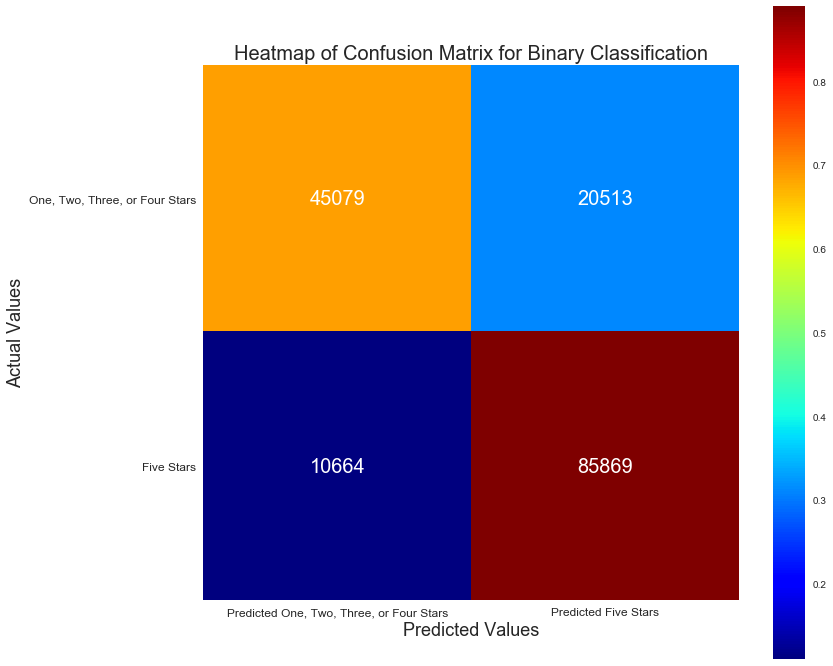

In [53]:
# Calculating the recall manually for by dividing each value in the row by the sum of the row
norm_conf = []
for i in con_mat:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)
    
fig = plt.figure(figsize=(12, 12))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, interpolation='nearest')

width, height = con_mat.shape

# Annotating each of the values in the confusion matrix onto the heatmap
for x in range(width):
    for y in range(height):
        ax.annotate(str(con_mat[x][y]), xy=(y, x),
                   horizontalalignment='center', verticalalignment='center', color='white',
                   fontsize=20)

cb = fig.colorbar(res)

xlabels = ['Predicted One, Two, Three, or Four Stars', 'Predicted Five Stars']
ylabels = ['One, Two, Three, or Four Stars', 'Five Stars']
plt.title('Heatmap of Confusion Matrix for Binary Classification', fontsize=20)
plt.xlabel('Predicted Values', fontsize=18)
plt.ylabel('Actual Values', fontsize=18)
plt.xticks(range(width), xlabels[:width], fontsize=12)
plt.yticks(range(height), ylabels[:height], fontsize=12)
plt.grid(False)
plt.show()

We can see from the classification report that our Binary classification model correctly predicted five star ratings 89% of the time, while only predicting non-five star ratings correclty 69% of the time. This is at least partly due to the model overpredicting five stars, with around 10,000 more predictions of five stars then there were actual ratings.

##### Multiclass Classification Model

In [54]:
multiclass_predicted = multiclass_lsvc.predict(modeling_tfidf_X_test)

multiclass_con_mat = confusion_matrix(multiclass_y_test, multiclass_predicted)

multiclass_confusion = pd.DataFrame(multiclass_con_mat, index=['One, Two or Three Stars', 
        'Four Stars', 'Five Stars'], columns=['Predicted One, Two, or Three Stars', 
                                    'Predicted Four Stars', 'Predicted Five Stars'])
confusion

,Predicted Not Five Stars,Predicted Five Stars
Not Five Stars,45079,20513
Five Stars,10664,85869


In [55]:
print(classification_report(multiclass_y_test, multiclass_predicted))

             precision    recall  f1-score   support

          0       0.76      0.74      0.75     32156
          1       0.60      0.26      0.36     33436
          2       0.77      0.93      0.85     96533

avg / total       0.73      0.76      0.73    162125



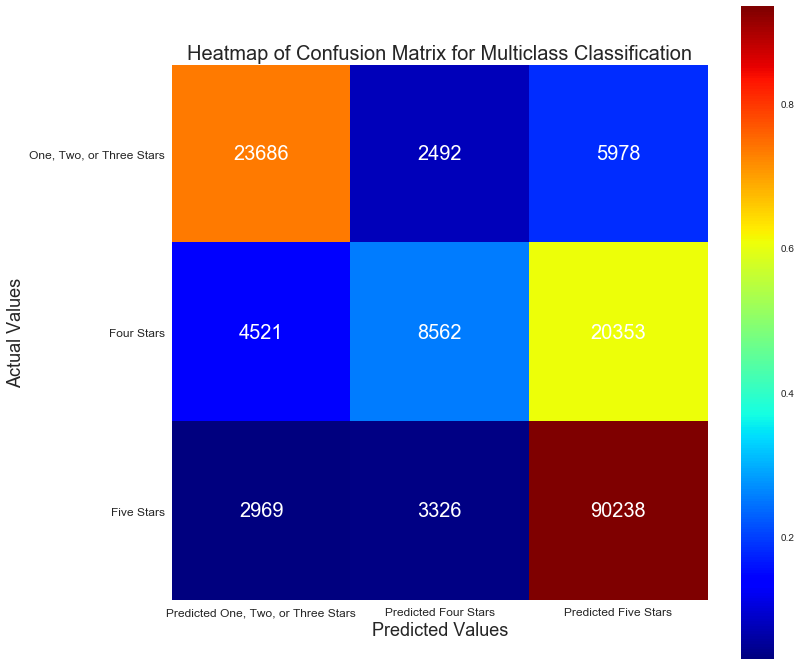

In [56]:
norm_conf = []
for i in multiclass_con_mat:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)
    
fig = plt.figure(figsize=(12, 12))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, interpolation='nearest')

width, height = multiclass_con_mat.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(multiclass_con_mat[x][y]), xy=(y, x),
                   horizontalalignment='center', verticalalignment='center', color='white',
                   fontsize=20)

cb = fig.colorbar(res)

xlabels = ['Predicted One, Two, or Three Stars', 'Predicted Four Stars', 'Predicted Five Stars']
ylabels = ['One, Two, or Three Stars', 'Four Stars', 'Five Stars']
plt.title('Heatmap of Confusion Matrix for Multiclass Classification', fontsize=20)
plt.xticks(range(width), xlabels[:width], fontsize=12)
plt.yticks(range(height), ylabels[:height], fontsize=12)
plt.xlabel('Predicted Values', fontsize=18)
plt.ylabel('Actual Values', fontsize=18)
plt.grid(False)
plt.show()

Separating out the four star ratings from all of the other non-five star ratings makes our model even better at predicting five star ratings, going from 89% to 93% recall. It also correctly predicts one, two, or three star ratings 74% of the time. However, it completely fails to predict four star ratings, correctly predicting those only 26% of the time, with ~60% of them being misclassified as five stars.

This makes sense to me as four star ratings would a lot of the time consist of mostly positive words, with some some negative words making up the 'but' of the review that stops it from being five-star worthy.

This model also overpredicts five star ratings even more than the binary classification model, with about ~20,000 more predictions of five stars than there were actual five star ratings.

### What can we Learn?

A possible business-use for this project would be pulling out words that are strong predictors of five star ratings that could possibly be used to guide production of technological products towards certain features. To take a look at if this pans out, we will pull out the feature names from our original TFIDF Vectorizer fits, and put them in a dataframe with their coefficients, then sort by them by how strong of a predictor they are.

In [57]:
# Creating separate feature names for words from the summary and text columns, so that words
# that appear in both are separated and easily readable.

text_features = []
for feature in text_tfidf.get_feature_names():
    text_feature = 'text_'+feature
    text_features.append(text_feature)
    
summary_features = []
for feature in summary_tfidf.get_feature_names():
    summary_feature = 'summary_'+feature
    summary_features.append(summary_feature)

In [58]:
## Since the coefficients from the model will be in the same order as the original dataframe
## that it was trained to, we can just take the first 5500 (to exclude the coefficients from
## the non-TFIDF columns) and put them in a dataframe with the matching feature names created
## above.

# feature_coefficients = \
#                         pd.DataFrame(list(zip((text_features + summary_features), 
#                         gs_lsvc.coef_[:, :5500].tolist()[0])), 
#                         columns=['feature', 'coefficient'])

# # Saving this dataframe as a csv in case of kernel death so that the tfidf does not need to be
# # run again.
# feature_coefficients.to_csv('feature_coefficients.csv', index=False)

In [59]:
feature_coefficients = pd.read_csv('feature_coefficients.csv')

In [60]:
# Taking just the top 20 words with the strongest coefficients (positive or negative) by
# sorting them by the absolute value of the coefficient

top20_features = feature_coefficients.reindex(feature_coefficients.coefficient.abs()
                            .sort_values(inplace=False, ascending=False).index).iloc[:20, :]

# Reseting the index
top20_features.index = range(20)

In [61]:
# Getting lists of the values of both the word and coefficient from the top 20 features so that
# they can be graphed easily. Reversing is so that the order of the graph is to my liking.

top20_coefs = top20_features['coefficient'].values.tolist()
top20_coefs.reverse()

top20_words = top20_features['feature'].values.tolist()
top20_words.reverse()

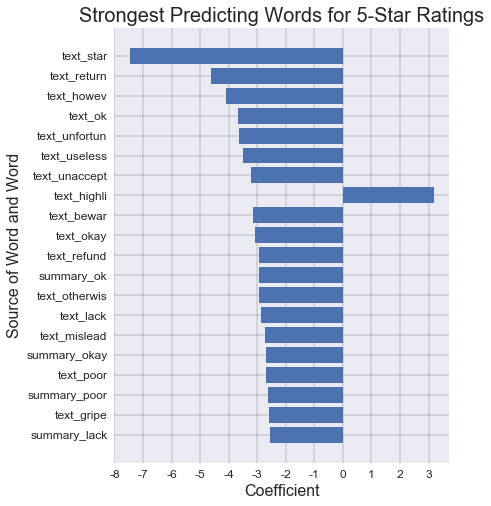

In [62]:
plt.figure(figsize=(6,8))
plt.barh(np.arange(len(top20_words)), top20_coefs)
plt.title('Strongest Predicting Words for 5-Star Ratings', fontsize=20)
plt.grid(color='black', lw=0.2)
plt.xticks(np.arange(-8,4), range(-8,4), fontsize=12)
plt.xlabel('Coefficient', fontsize=16)
plt.ylabel('Source of Word and Word', fontsize=16)
plt.yticks(np.arange(len(top20_words)), top20_words, fontsize=12)
plt.show()

We can see that of the top 20 strongest predictors of a review's rating, only one of them, 'highly' in the text of a review, is indicative of a five star rating. The rest all pull towards a non-five star rating, with the word 'star' in the text of a review being the strongest predictor by far. I would assume that this means when a person is leaving a negative review, they also like to say what rating they are giving. Since these are almost completely negative coefficients, and I believe that the best information for business-use would be what people are looking for that make it worthy of a five star reivew, we will now look at only the top 20 positive coefficients.

In [63]:
# Taking just the strongest positive features
top20_positive_features = feature_coefficients.reindex(feature_coefficients.coefficient
                            .sort_values(inplace=False, ascending=False).index).iloc[:20, :]

top20_positive_features.index = range(20)

In [64]:
top20_positive_coefs = top20_positive_features['coefficient'].values.tolist()
top20_positive_coefs.reverse()

top20_positive_words = top20_positive_features['feature'].values.tolist()
top20_positive_words.reverse()

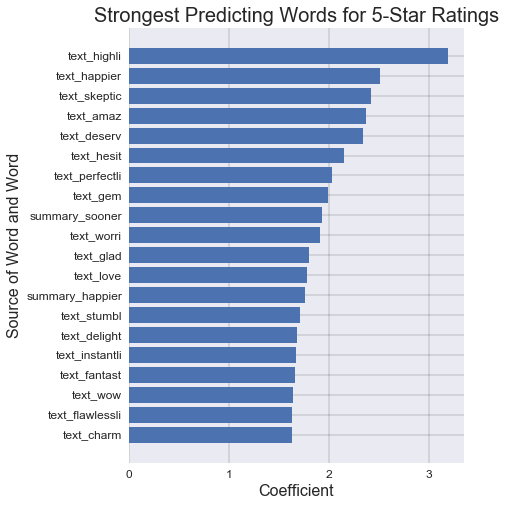

In [65]:
plt.figure(figsize=(6,8))
plt.barh(np.arange(len(top20_positive_words)), top20_positive_coefs)
plt.title('Strongest Predicting Words for 5-Star Ratings', fontsize=20)
plt.grid(color='black', lw=0.2)
plt.xticks(np.arange(4), range(4), fontsize=12)
plt.xlabel('Coefficient', fontsize=16)
plt.ylabel('Source of Word and Word', fontsize=16)
plt.yticks(np.arange(len(top20_positive_words)), top20_positive_words, fontsize=12)
plt.show()

Unfortunately, all of these positive words seem quite generic, and do not look like they would have much use for a business looking for features to incorporate into their products. To find some words that may actually have a use, we'll have to look further into the dataframe.

In [66]:
feature_coefficients.reindex(feature_coefficients.coefficient
                            .sort_values(inplace=False, ascending=False).index)

,feature,coefficient
1347,text_highli,3.194384
1291,text_happier,2.509739
2612,text_skeptic,2.424620
93,text_amaz,2.371493
741,text_deserv,2.341632
1336,text_hesit,2.148273
2083,text_perfectli,2.034103
1195,text_gem,1.997776
5092,summary_sooner,1.937179
3271,text_worri,1.914985


From looking through just the top 300 positive words to try to find some that may be useful to guide production, I found quite a few non-generic words that describe something about a product that obviously quite a lot of people included in their five star review.

In [67]:
feature_coefficients.reindex(feature_coefficients.coefficient
                            .sort_values(inplace=False, ascending=False).index).loc[1032]

feature        text_fast
coefficient      1.26428
Name: 1032, dtype: object

In [68]:
feature_coefficients.reindex(feature_coefficients.coefficient
                            .sort_values(inplace=False, ascending=False).index).loc[3084]

feature        text_unobtrus
coefficient          1.25127
Name: 3084, dtype: object

In [69]:
feature_coefficients.reindex(feature_coefficients.coefficient
                            .sort_values(inplace=False, ascending=False).index).loc[2261]

feature        text_quietli
coefficient         1.12112
Name: 2261, dtype: object

In [70]:
feature_coefficients.reindex(feature_coefficients.coefficient
                            .sort_values(inplace=False, ascending=False).index).loc[988]

feature        text_expens
coefficient       0.926858
Name: 988, dtype: object

In [71]:
feature_coefficients.reindex(feature_coefficients.coefficient
                            .sort_values(inplace=False, ascending=False).index).loc[2791]

feature        text_sturdi
coefficient       0.908685
Name: 2791, dtype: object

In [72]:
feature_coefficients.reindex(feature_coefficients.coefficient
                            .sort_values(inplace=False, ascending=False).index).loc[2259]

feature        text_quiet
coefficient      0.874013
Name: 2259, dtype: object

In [73]:
feature_coefficients.reindex(feature_coefficients.coefficient
                            .sort_values(inplace=False, ascending=False).index).loc[877]

feature        text_easier
coefficient       0.828364
Name: 877, dtype: object

In [74]:
feature_coefficients.reindex(feature_coefficients.coefficient
                            .sort_values(inplace=False, ascending=False).index).loc[462]

feature        text_cheapest
coefficient         0.788212
Name: 462, dtype: object

In [75]:
feature_coefficients.reindex(feature_coefficients.coefficient
                            .sort_values(inplace=False, ascending=False).index).loc[229]

feature        text_bargain
coefficient        0.777424
Name: 229, dtype: object

In [76]:
feature_coefficients.reindex(feature_coefficients.coefficient
                            .sort_values(inplace=False, ascending=False).index).loc[3890]

feature        summary_easiest
coefficient           0.768278
Name: 3890, dtype: object

In [77]:
feature_coefficients.reindex(feature_coefficients.coefficient
                            .sort_values(inplace=False, ascending=False).index).loc[5054]

feature        summary_slick
coefficient         0.736406
Name: 5054, dtype: object

So our list of possible useful words is: fast, unobtrusive, quietly, expensive, sturdy, quiet, easier, cheapest, bargain, easiest, and slick. Two of these are obviously basically repeats of the same root word (easy and quiet), which mean they should be considered more than their respective coefficients might suggest. Some of these might seem to be fairly obvious positive words when talking about a technological product, but they definitely show what people are looking for in order to give a product a five star rating.

### Next Steps

For the next steps of this project, I have a couple different ideas I would like to try out in order to try make my model even better in places where it has not performed the greatest.

First I would like to try transforming my text data into numerical columns using a vectorizer that takes into account the context of each word using surrounding words. I know something like this exists out there but I am unsure of exactly what it is called. I feel like while this may not improve the accuracy of my model too much, it would be able to provide more information when looking at what words are strong predictors of a five star review, which could make the business use of the model more robust.

I would also like to try oversampling the non-five-star reviews to attempt to make my model stronger, and better at predicting reviews that weren’t five stars. Currently my model is overpredicting five stars, which could at least partly be because the dataset is made up of about 60% five star reviews, so it is a little bit imbalanced. While using something like SMOTE has not worked out very well at all for me in the past, it seems like something that would take some getting used to and would be incredibly useful if mastered. 
